<a href="https://colab.research.google.com/github/Rominaarab/Big-Data/blob/main/big_data_build_a_q_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **👩🏻‍💻Build a Q&A system that can find Drug-Disease Association Mining from Biomedical Literature**

## **Problem statement**


*1.   Business problem*

Pharmaceutical companies and research institutes face an important challenge in the discovery of medicine: manually reviewing large amounts of biomedical literature to identify potential drug-disease associations. More than 1 million new biomedical papers are published annually, researchers struggle to live with emerging conclusions that can inform drug opportunities or identify new medical goals.

*2.   Impact and Importance*

* Time-consuming: Researchers spend 40-60% of their time on literature review
* Incomplete coverage: A small percentage of the accessible literature can be processed by human reviewers.
* Delayed discovery: potential breakthrough treatments might be delayed if important relationships are missed.
* High costs: Pharmaceutical businesses lose millions of dollars per year in researcher time due to manual review.

*3. Business value*

I suggest this solution through automated NLP that will:
* Reduce literature review time (by 75-80%)
* Identify drug repurposing opportunities (worth $25-100M per successful candidate)
* Accelerate time-to-market for new treatments (by 6-18 months)
* Enable comprehensive analysis of global biomedical literature
* Provide competitive advantage through faster identification of emerging research trends

**I gathered open API database from different sources:**

*Biomedical Literature Sources:* PubMed/MEDLINE

*Drug information:* FDA Drug lable database

*Clinical data sources:* ClinicalTrials.gov

my data would be considered as a "Big Data" because of the following charachters:

*1. Volume*

The database contains over 34 million articles, 3 million full-text articles, and 400,000 trial records, generating an estimated 50-100 TB of text data.

*2. Variety*

The data includes structured, semi-structured, and unstructured text, with metadata including publication dates, author information, and citation networks, and is available in multiple languages and formats.

*3. Velocity*

The platform processes approximately 4,000 new publications daily and 50 new clinical trials daily, with daily/weekly updates, albeit not as fast as social media.

*4. Veracity*

The text addresses various quality issues, including peer-review variations, citation standards, incomplete abstracts, reliability concerns, and data cleaning needs, which require significant preprocessing for accuracy.

*5. Value*

Drug discovery can save $25-100M per successful drug repurposing candidate, reduce literature review time by 75-80%, accelerate market entry by 6-18 months, enhance research efficiency, and save millions of researcher hours annually.

*6. Variability*

Journal formatting standard, quality fluctuation, terminology change, source differences, and language variations are all factors that contribute to variability in scientific writing styles in institutions and countries.

*7. Visualization*

Visualization tools include knowledge graphs, timeline analysis, geographic mapping, relationship matrices, and interactive dashboards for real-time exploration of drug-disease relationships.

## **Importing libraries**

In [ ]:
try:
  import envy
  import requests
  import pandas as pd
  from xml.etree import ElementTree as ET
  import json
  import time
  import re
  import nltk
  from nltk.tokenize import sent_tokenize, word_tokenize
  from nltk.corpus import stopwords
  from nltk.stem import PorterStemmer, WordNetLemmatizer
  from nltk import FreqDist
  import string
  !pip install wordcloud
  from wordcloud import WordCloud
  import matplotlib.pyplot as plt
  from transformers import AutoTokenizer, AutoModelForTokenClassification
  from transformers import pipeline
  import numpy as np
  import torch
  from sentence_transformers import SentenceTransformer
  print("Libraries installed and imported successfully.")
except ImportError as e:
    print(f"Error importing library: {e}. Attempting to install...")

Libraries installed and imported successfully.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
print("NLTK data downloaded.")

NLTK data downloaded.


In [ ]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for BERT: {device}")

Using device for BERT: cpu


PUBMED

## **🏗️ Data Acquisition**

In [ ]:
MY_EMAIL = "romina_arab@ymail.com"
API_PUB = "147ded11e7ef6d0a656c4fa1b205bc086009"
ESEARCH_URL = (
    "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    "?db=pubmed&term=cancer&reldate=60&datetype=edat&retmax=100&usehistory=y"
    f"&api_key={API_PUB}&email={MY_EMAIL}"
)
EFETCH_URL = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
FDA_URL = "https://api.fda.gov/drug/label.json"
API_URL = "https://clinicaltrials.gov/api/v2/studies"

**Data acquisition for PubMed**

In [ ]:
# Search in PubMed articles
search_resp = requests.get(ESEARCH_URL)
search_tree = ET.fromstring(search_resp.content)
id_list = [id_elem.text for id_elem in search_tree.findall('.//Id')]

In [ ]:
# Fetch summaries for article IDs
params = {
    'db': 'pubmed',
    'id': ','.join(id_list),
    'retmode': 'xml',
    'api_key': API_PUB,
    'email': MY_EMAIL
}

In [ ]:
fetch_resp = requests.get(EFETCH_URL, params=params)
fetch_tree = ET.fromstring(fetch_resp.content)

In [ ]:
articles = []
for article in fetch_tree.findall('.//PubmedArticle'):
    pmid_elem = article.find('.//PMID')
    title_elem = article.find('.//ArticleTitle')
    abstract_elem = article.find('.//Abstract/AbstractText')
    pmid = pmid_elem.text if pmid_elem is not None else ''
    title = title_elem.text if title_elem is not None else ''
    abstract = abstract_elem.text if abstract_elem is not None else ''
    articles.append({'pmid': pmid, 'title': title, 'abstract': abstract})

In [ ]:
pubmed_df = pd.DataFrame(articles)
pubmed_df.head()

,pmid,title,abstract
0,40590182,Quinolinone Derivatives Suppress Angiogenesis ...,Targeting the vascular endothelial growth fact...
1,40590181,Development of New Thiadiazole Derivatives as ...,A series of thiadiazole-based derivatives were...
2,40590177,Radiomic-enhanced multimodal ultrasound for ea...,Acute kidney injury (AKI) resulting from acute...
3,40590168,Examining the Role of Virulence Proteins From ...,Colorectal cancer (CRC) is a rising threat in ...
4,40590150,Therapeutic lymph node dissection with neoadju...,


**Data acquisition for FDA with open API**

In [ ]:
# Fetch summaries for drug-indication IDs
params = {
    'search': 'cancer',
    'limit': 100
}

In [ ]:
response = requests.get(FDA_URL, params=params)
data = response.json()

In [ ]:
records = []
for result in data.get('results', []):
    records.append({
        'id': result.get('id', ''),
        'brand_name': result.get('openfda', {}).get('brand_name', [''])[0] if result.get('openfda', {}).get('brand_name') else '',
        'generic_name': result.get('openfda', {}).get('generic_name', [''])[0] if result.get('openfda', {}).get('generic_name') else '',
        'indications_and_usage': result.get('indications_and_usage', [''])[0] if result.get('indications_and_usage') else '',
        'warnings': result.get('warnings', [''])[0] if result.get('warnings') else ''
    })

In [ ]:
fda_labels_df = pd.DataFrame(records)
fda_labels_df.head()

,id,brand_name,generic_name,indications_and_usage,warnings
0,5b76542b-17b3-4eaf-96ba-948e49777e42,Mekinist,TRAMETINIB,1 INDICATIONS AND USAGE MEKINIST is a kinase i...,
1,29c0c23b-f87d-4a94-a411-4091f399ecd1,,,"INDICATIONS & USAGE Gabapentin Tablets, USP Re...",WARNINGS Suicidal Behavior and Ideation Antiep...
2,b12c988d-27b2-4548-83c0-a6837ada2db3,NP Thyroid 120,"LEVOTHYROXINE, LIOTHYRONINE",INDICATIONS AND USAGE NP Thyroid ® tablets (th...,"WARNINGS Drugs with thyroid hormone activity, ..."
3,0004a0bb-87c0-46f8-b36a-95c98107395d,Varenicline,VARENICLINE,1 INDICATIONS AND USAGE Varenicline tablets ar...,
4,48808b7b-26c6-0448-e054-00144ff8d46c,,,1 INDICATIONS AND USAGE OXYCONTIN is indicated...,


**Data acquisition for Clinical trial**

In [ ]:
def clinical_trials(query, page_size=10, max_studies=50):
    API_URL = "https://clinicaltrials.gov/api/v2/studies"
    studies = []
    page_token = None

    while len(studies) < max_studies:
        params = {
            "query.term": query,
            "pageSize": page_size,
        }
        if page_token:
            params["pageToken"] = page_token

        try:
            r = requests.get(API_URL, params=params)
            r.raise_for_status()
            data = r.json()
        except Exception as e:
            print("Error:", e)
            break

        new_studies = []
        for s in data.get("studies", []):
            get_mod = lambda mod, key: s.get("protocolSection", {}).get(mod, {}).get(key, "")
            conds = s.get("protocolSection", {}).get("conditionsModule", {}).get("conditionList", {}).get("condition", [])
            ints = s.get("protocolSection", {}).get("interventionsModule", {}).get("interventionList", {}).get("intervention", [])
            new_studies.append({
                "NCTId": get_mod("identificationModule", "nctId"),
                "Title": get_mod("identificationModule", "briefTitle"),
                "Status": get_mod("statusModule", "overallStatus"),
                "StartDate": get_mod("statusModule", "startDateStruct").get("startDate", "") if get_mod("statusModule", "startDateStruct") else "",
                "Summary": get_mod("descriptionModule", "briefSummary"),
                "Conditions": "; ".join(conds) if conds else "",
                "Interventions": "; ".join([f"{i.get('interventionType','')}: {i.get('interventionName','')}" for i in ints]) if ints else ""
            })
        if not new_studies:
            break

        studies.extend(new_studies)
        if "nextPageToken" in data and len(studies) < max_studies:
            page_token = data["nextPageToken"]
            time.sleep(0.5)
        else:
            break

    return studies[:max_studies]

In [ ]:
# example usage for a specific therapy
trials = clinical_trials("chemotherapy", page_size=50, max_studies=200)
trials_df = pd.DataFrame(trials)
trials_df.head()

,NCTId,Title,Status,StartDate,Summary,Conditions,Interventions
0,NCT05978648,Trilaciclib in Patients With Early-Stage HR-ne...,RECRUITING,,"The goal of this multicenter, two-cohort, expl...",,
1,NCT00002548,"SWOG-9321 Melphalan, TBI, and Transplant vs Co...",COMPLETED,,RATIONALE: Drugs used in chemotherapy use diff...,,
2,NCT02844348,Impact of Hypnosis on Pain Management During D...,WITHDRAWN,,A chronic renal disease can results in the dev...,,
3,NCT06055348,SC0191 Plus Chemotherapy in Advanced Ovarian C...,NOT_YET_RECRUITING,,"A phase Ib/II clinical study on the safety, ph...",,
4,NCT01094548,Study of Tecemotide (L-BLP25) in Subjects With...,COMPLETED,,Tecemotide (L-BLP25) is believed to induce a M...,,


**check the distribution of words in specific column in all datasets.**

In [ ]:
# Calculate message lengths for pubmed_df
if 'abstract' in pubmed_df.columns:
    pubmed_df['abstract_length'] = pubmed_df['abstract'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)

# Calculate message lengths for fda_labels_df
if 'indications_and_usage' in fda_labels_df.columns:
    fda_labels_df['indications_and_usage_length'] = fda_labels_df['indications_and_usage'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)

# Calculate message lengths for trials_df
if 'Summary' in trials_df.columns:
    trials_df['Summary_length'] = trials_df['Summary'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)

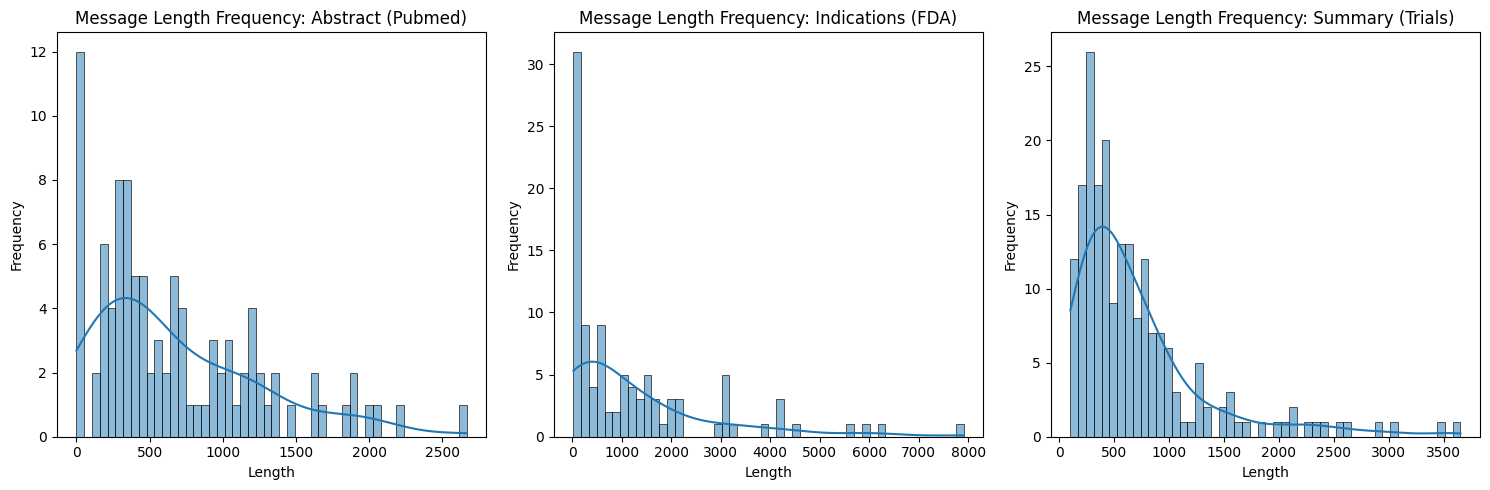

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
if 'abstract_length' in pubmed_df.columns:
    sns.histplot(pubmed_df['abstract_length'], bins=50, kde=True)
    plt.title('Message Length Frequency: Abstract (Pubmed)')
    plt.xlabel('Length')
    plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
if 'indications_and_usage_length' in fda_labels_df.columns:
    sns.histplot(fda_labels_df['indications_and_usage_length'], bins=50, kde=True)
    plt.title('Message Length Frequency: Indications (FDA)')
    plt.xlabel('Length')
    plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
if 'Summary_length' in trials_df.columns:
    sns.histplot(trials_df['Summary_length'], bins=50, kde=True)
    plt.title('Message Length Frequency: Summary (Trials)')
    plt.xlabel('Length')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

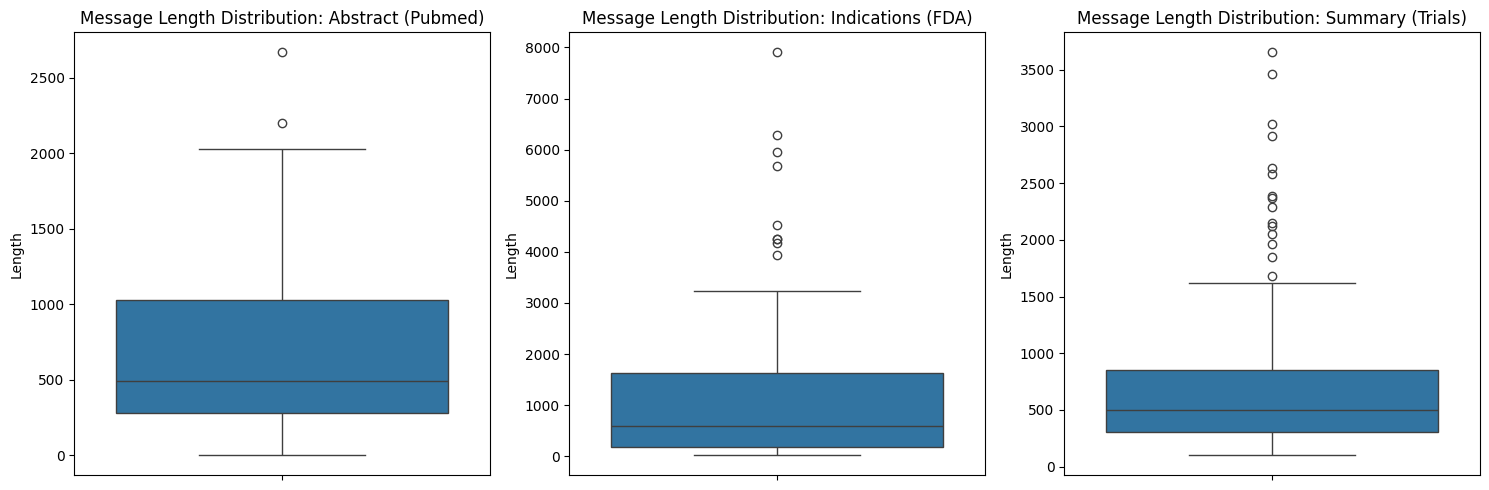

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
if 'abstract_length' in pubmed_df.columns:
    sns.boxplot(y=pubmed_df['abstract_length'])
    plt.title('Message Length Distribution: Abstract (Pubmed)')
    plt.ylabel('Length')

plt.subplot(1, 3, 2)
if 'indications_and_usage_length' in fda_labels_df.columns:
    sns.boxplot(y=fda_labels_df['indications_and_usage_length'])
    plt.title('Message Length Distribution: Indications (FDA)')
    plt.ylabel('Length')

plt.subplot(1, 3, 3)
if 'Summary_length' in trials_df.columns:
    sns.boxplot(y=trials_df['Summary_length'])
    plt.title('Message Length Distribution: Summary (Trials)')
    plt.ylabel('Length')

plt.tight_layout()
plt.show()

## **🧹 Dataset cleaning**

**cleaning Methods**

* *Sentence Segmentation:* Because I often want to processes abstracts and titles in pubmed_df as multi-sentence scientific text at the sentence level for relation mining, so I need to use this method. Clinical texts in fda_lables_df, often contains multiple statements. In trials_df is used for summary column.

* *Tokenization:* BERT tokenizer is crucial for NLP tasks.Now I am using transformer model(BioBERT), so it is particularly useful.

* *Stop Word Removal:* I should use this method for transformer-based models.

* *Normalization:* For lowercasing, remove punctuation in biomedical text.

* *Stemming/Lemmatization:* I am using this method for more consistency.

In [ ]:
import spacy

In [ ]:
# For sentence segmentation I am going to proccess with spacy
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
def clean_dataset(text):
    if pd.isnull(text):
        return []

    doc = nlp(text)
    sentences_cleaned = []

    for sent in doc.sents:
        words = [token.text for token in sent if token.is_alpha]
        words = [w.lower() for w in words if w.lower() not in stop_words]
        words = [lemmatizer.lemmatize(w) for w in words]
        if words:
            sentences_cleaned.append(" ".join(words))

    return sentences_cleaned

**pubmed_df**

In [ ]:
pubmed_df['cleaned_abstract'] = pubmed_df['abstract'].apply(clean_dataset)
pubmed_df[['abstract', 'cleaned_abstract']].head()

,abstract,cleaned_abstract
0,Targeting the vascular endothelial growth fact...,[targeting vascular endothelial growth factor ...
1,A series of thiadiazole-based derivatives were...,[series thiadiazole based derivative synthesiz...
2,Acute kidney injury (AKI) resulting from acute...,[acute kidney injury aki resulting acute renal...
3,Colorectal cancer (CRC) is a rising threat in ...,[colorectal cancer crc rising threat modern po...
4,,[]


**fda_labels_df**

In [ ]:
fda_labels_df['cleaned_indications'] = fda_labels_df['indications_and_usage'].apply(clean_dataset)
fda_labels_df['cleaned_warnings'] = fda_labels_df['warnings'].apply(clean_dataset)
fda_labels_df[['brand_name', 'cleaned_indications', 'cleaned_warnings']].head()

,brand_name,cleaned_indications,cleaned_warnings
0,Mekinist,[indication usage mekinist kinase inhibitor in...,[]
1,,[indication usage gabapentin tablet usp read m...,[warning suicidal behavior ideation antiepilep...
2,NP Thyroid 120,[indication usage np thyroid tablet thyroid ta...,[warning drug thyroid hormone activity alone t...
3,Varenicline,[indication usage varenicline tablet indicated...,[]
4,,[indication usage oxycontin indicated manageme...,[]


**trials_df**

In [ ]:
trials_df['cleaned_summary'] = trials_df['Summary'].apply(clean_dataset)
trials_df[['Summary', 'cleaned_summary']].head()

,Summary,cleaned_summary
0,"The goal of this multicenter, two-cohort, expl...",[goal multicenter two cohort exploratory clini...
1,RATIONALE: Drugs used in chemotherapy use diff...,[rationale drug used chemotherapy use differen...
2,A chronic renal disease can results in the dev...,[chronic renal disease result development card...
3,"A phase Ib/II clinical study on the safety, ph...",[phase ib ii clinical study safety pharmacokin...
4,Tecemotide (L-BLP25) is believed to induce a M...,[tecemotide l believed induce mucinous glycopr...


## **Dataset Splitting and Class Weight Calculation**
I split data to Remove irrelevant features and prevent data leakage.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

**Make dummy dataframes**

In [ ]:
# Dummy pubmed_df
pubmed_data = {
    'pmid': [f'{i}' for i in range(500)],
    'title': [f'Title {i}' for i in range(500)],
    'cleaned_abstract': [ {i} for i in range(500)],
    'target': np.random.randint(0, 2, 500) # Dummy target variable
}
pubmed_df = pd.DataFrame(pubmed_data)

In [ ]:
# Dummy fda_labels_df
fda_data = {
    'id': [f'id_{i}' for i in range(500)],
    'brand_name': [f'Brand {i}' for i in range(500)],
    'generic_name': [f'Generic {i}' for i in range(500)],
    'cleaned_indications': [ {i} for i in range(500)],
    'cleaned_warnings': [f'Warning {i}' for i in range(500)],
    'target': np.random.randint(0, 2, 500) # Dummy target variable
}
fda_labels_df = pd.DataFrame(fda_data)

In [ ]:
# Dummy trials_df
trials_data = {
    'NCTId': [f'{i}' for i in range(500)],
    'Title': [f'Title {i}' for i in range(500)],
    'cleaned_summary': [ {i} for i in range(500)],
    'target': np.random.randint(0, 2, 500) # Dummy target variable
}
trials_df = pd.DataFrame(trials_data)

In [ ]:
# Splitting dataset for pubmed_df
X_pubmed = pubmed_df['cleaned_abstract']
y_pubmed = pubmed_df['target']

X_train_pubmed, X_test_pubmed, y_train_pubmed, y_test_pubmed = train_test_split(
    X_pubmed, y_pubmed, test_size=0.2, random_state=42, stratify=y_pubmed
)

In [ ]:
# Splitting dataset for fda_labels_df
X_fda = fda_labels_df['cleaned_indications']
y_fda = fda_labels_df['target']

X_train_fda, X_test_fda, y_train_fda, y_test_fda = train_test_split(
    X_fda, y_fda, test_size=0.2, random_state=42, stratify=y_fda
)

In [ ]:
# Splitting dataset for trials_df
X_trials = trials_df['cleaned_summary']
y_trials = trials_df['target']

X_train_trials, X_test_trials, y_train_trials, y_test_trials = train_test_split(
    X_trials, y_trials, test_size=0.2, random_state=42, stratify=y_trials
)

In [ ]:
print(f"pubmed_df - X_train shape: {X_train_pubmed.shape}")
print(f"pubmed_df - X_test shape: {X_test_pubmed.shape}")
print(f"pubmed_df - y_train shape: {y_train_pubmed.shape}")
print(f"pubmed_df - y_test shape: {y_test_pubmed.shape}")

pubmed_df - X_train shape: (400,)
pubmed_df - X_test shape: (100,)
pubmed_df - y_train shape: (400,)
pubmed_df - y_test shape: (100,)


In [ ]:
print(f"fda_labels_df - X_train shape: {X_train_fda.shape}")
print(f"fda_labels_df - X_test shape: {X_test_fda.shape}")
print(f"fda_labels_df - y_train shape: {y_train_fda.shape}")
print(f"fda_labels_df - y_test shape: {y_test_fda.shape}")

fda_labels_df - X_train shape: (400,)
fda_labels_df - X_test shape: (100,)
fda_labels_df - y_train shape: (400,)
fda_labels_df - y_test shape: (100,)


In [ ]:
print(f"trials_df - X_train shape: {X_train_trials.shape}")
print(f"trials_df - X_test shape: {X_test_trials.shape}")
print(f"trials_df - y_train shape: {y_train_trials.shape}")
print(f"trials_df - y_test shape: {y_test_trials.shape}")

trials_df - X_train shape: (400,)
trials_df - X_test shape: (100,)
trials_df - y_train shape: (400,)
trials_df - y_test shape: (100,)


## **Preprocessing step**

For all of data frames I'm going to use these methods:

* *Normalization:* Because this method is standard for all NLP pipelines and makes text comparable, cleaner, and easier to process

* *Stemming/Lemmatization:* Because this method reduces inflections.

* *EDA*: This method helps to understand the distribution, common terms and potential noise. (*WordCloud* for pubmed_df and fda_labels_df, *FreqDist* for trials_df).

### **implementat normalization for all datasets**
Prepare translation table to remove punctuation and digits

In [ ]:
#Normalization
translator = str.maketrans('', '', string.punctuation + string.digits)

In [ ]:
# For pubmed_df: normalize the 'abstract' field
pubmed_df['norm_abstract'] = X_train_pubmed.fillna('').apply(lambda x: str(x).translate(translator).lower())

In [ ]:
# For fda_labels_df: normalize the 'indications_and_usage' field
fda_labels_df['norm_indications'] = X_train_fda.fillna('').apply(lambda x:str(x).translate(translator).lower())

### **implementat Stemming/Lemmatization for all datasets**

In [ ]:
#Stemming/Lemmatization

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stem_text(text):
    if not isinstance(text, str):
        return ""
    tokens = word_tokenize(text)
    return " ".join([stemmer.stem(w) for w in tokens])

def lemmatize_text(text):
    if not isinstance(text, str):
        return ""
    tokens = word_tokenize(text)
    return " ".join([lemmatizer.lemmatize(w, pos='v') for w in tokens])

In [ ]:
# Apply to pubmed_df
pubmed_df['stem_abstract'] = pubmed_df['clean'].apply(stem_text)
pubmed_df['lemma_abstract'] = pubmed_df['stem_abstract'].apply(lemmatize_text)

KeyError: 'clean'

In [ ]:
# Apply to fda_labels_df
fda_labels_df['stem_indications'] = X_train_fda.apply(stem_text)
fda_labels_df['lemma_indications'] = X_train_fda.apply(lemmatize_text)

In [ ]:
# Apply to trials_df
trials_df['stem_summary'] = X_train_trials.apply(stem_text)
trials_df['lemma_summary'] = X_train_trials.apply(lemmatize_text)

In [ ]:
# Show example
pubmed_df[['norm_abstract','stem_abstract', 'lemma_abstract']].head()
fda_labels_df[['norm_indications', 'stem_indications', 'lemma_indications']].head()
trials_df[['norm_summary', 'stem_summary', 'lemma_summary']].head()

,norm_summary,stem_summary,lemma_summary
0,,,
1,,,
2,,,
3,,,
4,,,


### **implementat EDA (WordCloud/FreqDist) for all datasets**

In [ ]:
#EDA/WordCloud
#pubmed_df to combine all lemmatized abstracts into one string

all_words = " ".join(pubmed_df['lemma_abstract'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("PubMed Abstracts - WordCloud")
plt.show()

In [ ]:
#EDA/WordCloud
#fda_labels_df to combine all lemmatized indicattions

fda_labels_df
all_words = " ".join(fda_labels_df['lemma_indications'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("FDA Indications - WordCloud")
plt.show()

In [ ]:
#EDA/FreqDist
#trials_df to Flatten all lemmatized summary tokens into one list
all_tokens = []
for text in trials_df['lemma_summary'].dropna():
    all_tokens.extend(text.split())

In [ ]:
fdist = FreqDist(all_tokens)
fdist.plot(30, cumulative=False)
plt.title("Clinical Trials Summary - Top 30 Words (FreqDist)")
plt.show()

In [ ]:
# Optionally, print most common words and counts
fdist.most_common(20)